In [ ]:
## Filament Rotation Scale Dependence (Eulerian Circulation V3)
## Data, Code, and Scope Declaration

# This notebook implements the A1 empirical analysis of filament-scale circulation
# in the large-scale cosmic velocity field. The analysis is designed to be fully
# model-agnostic and purely empirical.

### Authoritative Data Sources

# **Filament Geometry**
# - Filament geometry is derived from the DisPerSE skeleton:
#   `sdss_disperse_skeleton.NDskl`
# - Parsed and cleaned filament spine segments used for analysis are loaded from:
#   - `derived/filament_master_table_stage1.csv` (primary analysis sample)
#   - `derived/filament_master_table.csv` (full reference sample)

# **Velocity Field**
# - The large-scale velocity field is treated as an Eulerian observable.
# - Velocity grid / lookup assets are loaded from:
#   - `derived/velocity_assets/`
# - No galaxy spins or halo properties are used in this analysis.

### Estimator Code

# - Cylindrical ring estimators for Eulerian circulation and tangential velocity
#   are implemented in:
#   - `lib/filament_estimator.py`
# - This code is reused as a validated numerical implementation only.
# - All statistical results are recomputed within this notebook.

### Outputs and Reproducibility

# - All circulation profiles, null tests, and statistics shown here are generated
#   from scratch in this notebook.
# - Prior result files (e.g., in `outputs/` or `phase1_outputs/`) are not used as
#   inputs and serve only as legacy reference products.

### Scope and Constraints

# - This analysis is strictly empirical.
# - No cosmological, gravitational, or structure-formation model is assumed.
# - Conclusions are limited to:
#   - presence or absence of coherent circulation,
#   - scale dependence of the signal,
#   - statistical significance,
#   - robustness under null hypotheses.

# Any physical interpretation of detected (or absent) signals is explicitly
# deferred to subsequent work.

In [ ]:
###.  Cell 1
# Environment Setup and Reproducibility : This cell configures the execution environment, mounts Google Drive,
# defines authoritative data paths, and fixes random seeds to ensure reproducibility of all subsequent analyses.
# No data processing or analysis is performed in this cell.

# ============================================================
# Environment & reproducibility setup
# ============================================================

import os
import sys
import json
import zipfile
import numpy as np
import pandas as pd
import random

# ----------------------------
# Reproducibility
# ----------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# ----------------------------
# Mount Google Drive
# ----------------------------
from google.colab import drive
drive.mount('/content/drive')

# ----------------------------
# Base project path
# ----------------------------
PROJECT_ROOT = "/content/drive/MyDrive/SFH_filaments"

if not os.path.isdir(PROJECT_ROOT):
    raise FileNotFoundError(f"Project root not found: {PROJECT_ROOT}")

# ----------------------------
# Canonical subdirectories
# ----------------------------
PATHS = {
    "lib": os.path.join(PROJECT_ROOT, "lib"),
    "derived": os.path.join(PROJECT_ROOT, "derived"),
    "velocity_assets": os.path.join(PROJECT_ROOT, "derived", "velocity_assets"),
    "outputs": os.path.join(PROJECT_ROOT, "outputs"),
    "phase1_outputs": os.path.join(PROJECT_ROOT, "phase1_outputs"),
}

# Sanity checks
for key, path in PATHS.items():
    if not os.path.isdir(path):
        print(f"WARNING: missing directory → {key}: {path}")
    else:
        print(f"OK: {key} → {path}")

# ----------------------------
# Make estimator code importable
# ----------------------------
if PATHS["lib"] not in sys.path:
    sys.path.append(PATHS["lib"])

# Confirm estimator import
try:
    import filament_estimator
    print("Estimator loaded: filament_estimator.py")
except Exception as e:
    raise ImportError("Failed to import filament_estimator.py") from e

# ----------------------------
# Canonical data files (declared, not loaded yet)
# ----------------------------
FILAMENT_TABLE_STAGE1 = os.path.join(
    PATHS["derived"], "filament_master_table_stage1.csv"
)

FILAMENT_TABLE_FULL = os.path.join(
    PATHS["derived"], "filament_master_table.csv"
)

if not os.path.isfile(FILAMENT_TABLE_STAGE1):
    raise FileNotFoundError(f"Missing Stage-1 filament table: {FILAMENT_TABLE_STAGE1}")

if not os.path.isfile(FILAMENT_TABLE_FULL):
    print("NOTE: full filament table not found (optional)")

print("Environment setup complete.")






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
OK: lib → /content/drive/MyDrive/SFH_filaments/lib
OK: derived → /content/drive/MyDrive/SFH_filaments/derived
OK: velocity_assets → /content/drive/MyDrive/SFH_filaments/derived/velocity_assets
OK: outputs → /content/drive/MyDrive/SFH_filaments/outputs
OK: phase1_outputs → /content/drive/MyDrive/SFH_filaments/phase1_outputs
Estimator loaded: filament_estimator.py
Environment setup complete.


In [ ]:
# ============================================================
# Cell 2 — Data loading & validation (no analysis)
# ============================================================

from pathlib import Path

# ----------------------------
# Load Stage-1 filament table
# ----------------------------
df_stage1 = pd.read_csv(FILAMENT_TABLE_STAGE1)
print(f"Loaded Stage-1 filament table: {FILAMENT_TABLE_STAGE1}")
print(f"Rows: {len(df_stage1):,}  |  Columns: {df_stage1.shape[1]:,}")

# Quick peek
display(df_stage1.head(3))

# Column overview (compact)
print("\n--- Column list (first 40) ---")
cols = list(df_stage1.columns)
print(cols[:40])
if len(cols) > 40:
    print(f"... (+{len(cols)-40} more columns)")

print("\n--- Dtypes summary ---")
print(df_stage1.dtypes.value_counts())

# ----------------------------
# Minimal sanity checks
# ----------------------------
if len(df_stage1) == 0:
    raise ValueError("Stage-1 table is empty — cannot proceed.")

# Common expected identifiers (we don't assume exact names yet)
candidate_id_cols = [c for c in cols if "fid" in c.lower() or "fil" in c.lower() or "cp0" in c.lower()]
print("\n--- Candidate ID/grouping columns (heuristic) ---")
print(candidate_id_cols[:30])

# Coordinate-ish columns (heuristic)
candidate_xyz = [c for c in cols if c.lower() in ("x","y","z","x_mpc","y_mpc","z_mpc","x_mpch","y_mpch","z_mpch")]
candidate_ra_dec = [c for c in cols if "ra" in c.lower() or "dec" in c.lower()]
print("\n--- Candidate coordinate columns ---")
print("XYZ-like:", candidate_xyz)
print("RA/Dec-like:", candidate_ra_dec[:30])

# ----------------------------
# Inventory velocity assets
# ----------------------------
vel_dir = Path(PATHS["velocity_assets"])
if not vel_dir.exists():
    raise FileNotFoundError(f"velocity_assets directory not found: {vel_dir}")

vel_files = sorted([p.name for p in vel_dir.iterdir()])
print("\n=== velocity_assets/ contents ===")
for name in vel_files:
    print(" -", name)

# If there is exactly one zip, record it automatically
zip_files = [p for p in vel_dir.iterdir() if p.suffix.lower() == ".zip"]
if len(zip_files) == 1:
    VELOCITY_ZIP = str(zip_files[0])
    print(f"\nDetected velocity zip: {VELOCITY_ZIP}")
elif len(zip_files) == 0:
    print("\nNo .zip found in velocity_assets/ (that can still be OK if assets are unpacked).")
else:
    print("\nMultiple .zip files found — we will choose explicitly later:")
    for z in zip_files:
        print("  *", z.name)

# ----------------------------
# Inventory legacy outputs (reference only, not inputs)
# ----------------------------
phase_dir = Path(PATHS["phase1_outputs"])
phase_files = sorted([p.name for p in phase_dir.iterdir()]) if phase_dir.exists() else []
print("\n=== phase1_outputs/ contents (reference only) ===")
for name in phase_files:
    print(" -", name)

print("\nCell 2 complete: data loaded + assets inventoried.")

Loaded Stage-1 filament table: /content/drive/MyDrive/SFH_filaments/derived/filament_master_table_stage1.csv
Rows: 25  |  Columns: 15


,cp0,cp1,npts,x0,y0,z0,x1,y1,z1,cx,cy,cz,length_native,length_mpc,z_proxy
0,25158,22359,23,15.077143,34.653429,-0.016771,12.782786,33.072429,-0.380629,12.687174,35.233950,-0.063967,863.486113,12.335516,0.008744
1,30960,30961,21,23.673571,-30.650714,24.925000,21.442143,-19.357286,18.355286,23.518007,-21.908673,19.789218,1279.502842,18.278612,0.008813
2,30960,30962,12,23.673571,-30.650714,24.925000,16.757857,-24.068571,18.831143,18.787214,-27.297655,20.937369,978.336915,13.976242,0.009153



--- Column list (first 40) ---
['cp0', 'cp1', 'npts', 'x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'cx', 'cy', 'cz', 'length_native', 'length_mpc', 'z_proxy']

--- Dtypes summary ---
float64    12
int64       3
Name: count, dtype: int64

--- Candidate ID/grouping columns (heuristic) ---
['cp0']

--- Candidate coordinate columns ---
XYZ-like: []
RA/Dec-like: []

=== velocity_assets/ contents ===
 - CF4_empirical
 - VAI.json
 - vel_grid_analytic_swirl_v1.npz

No .zip found in velocity_assets/ (that can still be OK if assets are unpacked).

=== phase1_outputs/ contents (reference only) ===
 - A1V3_axisnull_percentiles_by_filament.csv
 - A1V3_farposnull_percentiles_by_filament.csv
 - A1V3_gamma_profiles_SEG.csv
 - A1V3_null_axis_envelope_meanAbsGamma.csv
 - A1V3_null_axis_randomized_FIL.csv
 - A1V3_null_far_envelope_meanAbsGamma.csv
 - A1V3_null_far_position_FIL.csv
 - A1V3_vphi_gamma_profiles_FIL.csv
 - A1V3_vphi_profiles_SEG.csv
 - null_axis_randomized_CF4_FIL.csv
 - null_axis_randomized_CF4_FIL

In [ ]:
# ============================================================
# Cell 3 — Schema validation + velocity asset discovery
# (still no circulation analysis)
# ============================================================

import os
from pathlib import Path

# ----------------------------
# 1) Strict schema validation
# ----------------------------
REQUIRED_COLS = [
    "cp0", "cp1", "npts",
    "x0","y0","z0","x1","y1","z1",
    "cx","cy","cz",
    "length_mpc"
]

missing = [c for c in REQUIRED_COLS if c not in df_stage1.columns]
if missing:
    raise ValueError(f"Stage-1 table missing required columns: {missing}")

# Basic sanity checks
if (df_stage1["length_mpc"] <= 0).any():
    bad = (df_stage1["length_mpc"] <= 0).sum()
    raise ValueError(f"Found {bad} segments with non-positive length_mpc.")

print("OK: Stage-1 filament table schema validated.")

# Filament grouping quick stats
n_seg = len(df_stage1)
n_fil = df_stage1["cp0"].nunique()
print(f"Segments: {n_seg:,} | Unique filaments (cp0): {n_fil:,}")

seg_per_fil = df_stage1.groupby("cp0").size()
print("Segments per filament (min/median/max):",
      int(seg_per_fil.min()),
      float(seg_per_fil.median()),
      int(seg_per_fil.max()))

print("length_mpc (min/median/max):",
      float(df_stage1["length_mpc"].min()),
      float(df_stage1["length_mpc"].median()),
      float(df_stage1["length_mpc"].max()))

# ----------------------------
# 2) Velocity asset discovery
# ----------------------------
# We want the EMPIRICAL velocity backend (CF4/CF3 grid or equivalent),
# NOT the analytic swirl validation grid.
#
# This cell searches your SFH_filaments project tree for plausible assets:
#   - .npz grids (vel_grid, cf4, cf3, velocity)
#   - .npy components
#   - .pkl/.pickle (sometimes used for interpolators)
#   - .h5/.hdf5 (rare)
#
# We will report candidates and choose in the next cell.

SEARCH_EXT = {".npz", ".npy", ".pkl", ".pickle", ".h5", ".hdf5", ".json"}
KEYWORDS = ["cf4", "cf3", "vel", "velocity", "grid", "cosmicflows", "flow"]

root = Path(PROJECT_ROOT)

candidates = []
for p in root.rglob("*"):
    if p.is_file() and p.suffix.lower() in SEARCH_EXT:
        name = p.name.lower()
        score = sum(k in name for k in KEYWORDS)
        # exclude obvious non-velocity tables
        if "filament_master_table" in name:
            continue
        # keep anything with at least one keyword or any npz
        if score > 0 or p.suffix.lower() == ".npz":
            candidates.append((score, str(p)))

# sort best-first (more keyword hits)
candidates_sorted = sorted(candidates, key=lambda x: (-x[0], x[1]))

print("\n=== Velocity/asset candidates discovered under PROJECT_ROOT ===")
for score, path in candidates_sorted[:40]:
    print(f"[score={score}] {path}")

if len(candidates_sorted) > 40:
    print(f"... (+{len(candidates_sorted)-40} more)")

# Highlight likely "analytic swirl" so we don't accidentally use it as empirical
analytic_hits = [p for s,p in candidates_sorted if "analytic_swirl" in p.lower()]
if analytic_hits:
    print("\nWARNING: Found analytic swirl test grid(s) (validation only):")
    for p in analytic_hits:
        print("  -", p)

print("\nCell 3 complete.")

OK: Stage-1 filament table schema validated.
Segments: 25 | Unique filaments (cp0): 21
Segments per filament (min/median/max): 1 1.0 2
length_mpc (min/median/max): 10.015219676423618 11.82237755653311 21.65869218734595

=== Velocity/asset candidates discovered under PROJECT_ROOT ===
[score=2] /content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz

  - /content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz

Cell 3 complete.


In [ ]:
# ============================================================
# Cell 4 — Load & validate empirical CF4 velocity field
# ============================================================

from astropy.io import fits

# ----------------------------
# Lock velocity source of truth
# ----------------------------
CF4_DIR = os.path.join(PATHS["velocity_assets"], "CF4_empirical")
CF4_FILE = os.path.join(CF4_DIR, "CF4gp_new_64-z008_velocity.fits")

if not os.path.isfile(CF4_FILE):
    raise FileNotFoundError(f"Empirical CF4 velocity file not found: {CF4_FILE}")

print("Using empirical velocity field:")
print(" →", CF4_FILE)

# ----------------------------
# Open FITS file
# ----------------------------
with fits.open(CF4_FILE) as hdul:
    print("\n=== FITS HDU list ===")
    hdul.info()

    # Assume primary data contains velocity grid
    vel_data = hdul[0].data
    vel_header = hdul[0].header

# ----------------------------
# Inspect data structure
# ----------------------------
print("\n=== Velocity grid inspection ===")
print("Data type:", type(vel_data))
print("Data shape:", vel_data.shape)
print("Data dtype:", vel_data.dtype)

# Header keywords of interest
print("\n=== Selected FITS header keywords ===")
for key in ["NAXIS", "NAXIS1", "NAXIS2", "NAXIS3",
            "CUNIT1", "CUNIT2", "CUNIT3",
            "CTYPE1", "CTYPE2", "CTYPE3",
            "CRVAL1", "CRVAL2", "CRVAL3",
            "CDELT1", "CDELT2", "CDELT3"]:
    if key in vel_header:
        print(f"{key:8s} : {vel_header[key]}")

# ----------------------------
# Sanity checks
# ----------------------------
if vel_data is None:
    raise ValueError("Velocity data array is empty.")

if vel_data.ndim not in (3, 4):
    raise ValueError(
        f"Unexpected velocity data dimensionality: {vel_data.ndim}. "
        "Expected 3D grid or 4D (component, x, y, z)."
    )

print("\nCF4 velocity field loaded and validated.")

Using empirical velocity field:
 → /content/drive/MyDrive/SFH_filaments/derived/velocity_assets/CF4_empirical/CF4gp_new_64-z008_velocity.fits

=== FITS HDU list ===
Filename: /content/drive/MyDrive/SFH_filaments/derived/velocity_assets/CF4_empirical/CF4gp_new_64-z008_velocity.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (64, 64, 64, 3)   float32   

=== Velocity grid inspection ===
Data type: <class 'numpy.ndarray'>
Data shape: (3, 64, 64, 64)
Data dtype: >f4

=== Selected FITS header keywords ===
NAXIS    : 4
NAXIS1   : 64
NAXIS2   : 64
NAXIS3   : 64

CF4 velocity field loaded and validated.


In [ ]:
# ============================================================
# Cell 5 — Discover CF4 grid mapping from FITS headers/HDUs
# ============================================================

from astropy.io import fits
from pathlib import Path
import numpy as np
import os

CF4_DIR = Path(os.path.join(PATHS["velocity_assets"], "CF4_empirical"))
fits_files = sorted([p for p in CF4_DIR.iterdir() if p.suffix.lower() == ".fits"])

print("CF4_empirical directory:", CF4_DIR)
print("FITS files found:")
for p in fits_files:
    print(" -", p.name)

if len(fits_files) == 0:
    raise FileNotFoundError("No .fits files found in CF4_empirical/")

def summarize_hdul(path):
    with fits.open(path) as hdul:
        print("\n====================================================")
        print("FILE:", path.name)
        hdul.info()
        # print header keys for each HDU (selected + WCS-like)
        for i, hdu in enumerate(hdul):
            hdr = hdu.header
            data = hdu.data
            shape = None if data is None else data.shape
            print(f"\n--- HDU {i}: {type(hdu).__name__} | shape={shape} ---")
            # print common WCS keys if present
            wcs_keys = []
            for k in hdr.keys():
                ku = k.upper()
                if ku.startswith(("CTYPE", "CUNIT", "CRVAL", "CRPIX", "CDELT", "CD", "PC")):
                    wcs_keys.append(k)
            # also include NAXIS* always
            base_keys = [k for k in ["NAXIS","NAXIS1","NAXIS2","NAXIS3","NAXIS4"] if k in hdr]
            # show a compact subset
            show_keys = base_keys + sorted(set(wcs_keys))[:40]
            for k in show_keys:
                if k in hdr:
                    print(f"{k:8s} : {hdr[k]}")
            # if WCS keys are huge, tell user
            if len(wcs_keys) > 40:
                print(f"... (+{len(wcs_keys)-40} more WCS-like keys)")

# Run summaries on all CF4 FITS files (they are small enough at 64^3)
for p in fits_files:
    summarize_hdul(p)

print("\nCell 5 complete: CF4 header/HDU scan finished.")

CF4_empirical directory: /content/drive/MyDrive/SFH_filaments/derived/velocity_assets/CF4_empirical
FITS files found:
 - CF4_new_128-z008_BoA.fits
 - CF4_new_128-z008_BoR.fits
 - CF4gp_new_128-z008_BoA.fits
 - CF4gp_new_128-z008_BoR.fits
 - CF4gp_new_64-z008_velocity.fits

FILE: CF4_new_128-z008_BoA.fits
Filename: /content/drive/MyDrive/SFH_filaments/derived/velocity_assets/CF4_empirical/CF4_new_128-z008_BoA.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (128, 128, 128)   float64   

--- HDU 0: PrimaryHDU | shape=(128, 128, 128) ---
NAXIS    : 3
NAXIS1   : 128
NAXIS2   : 128
NAXIS3   : 128

FILE: CF4_new_128-z008_BoR.fits
Filename: /content/drive/MyDrive/SFH_filaments/derived/velocity_assets/CF4_empirical/CF4_new_128-z008_BoR.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (128, 128, 128)   float64   

--- HDU 0: PrimaryHDU | shape=(128, 128, 128) ---
NAXIS    : 3


In [ ]:
# ============================================================
# Cell 6 — Discover CF4 grid mapping from filament_estimator.py
# ============================================================

import inspect
import re

src = inspect.getsource(filament_estimator)
print("filament_estimator.py loaded from:", filament_estimator.__file__)
print("\n=== Searching estimator source for mapping keywords ===")

patterns = [
    r"xmin", r"xmax", r"ymin", r"ymax", r"zmin", r"zmax",
    r"box", r"bounds", r"extent", r"dx", r"dy", r"dz",
    r"grid", r"origin", r"spacing", r"mpc", r"mpc/h", r"h\-?1"
]

lines = src.splitlines()
hits = []
for i, line in enumerate(lines, start=1):
    low = line.lower()
    if any(re.search(p, low) for p in patterns):
        hits.append((i, line))

if not hits:
    print("No obvious mapping keywords found in filament_estimator.py.")
else:
    print(f"Found {len(hits)} candidate lines:\n")
    for i, line in hits[:200]:
        print(f"{i:4d}: {line}")

    if len(hits) > 200:
        print(f"\n... (+{len(hits)-200} more hits)")

print("\nCell 6 complete.")

filament_estimator.py loaded from: /content/drive/MyDrive/SFH_filaments/lib/filament_estimator.py

=== Searching estimator source for mapping keywords ===
Found 62 candidate lines:

   3: Minimal Eulerian filament rotation estimators for Phase 1 (GRID backend).
   6: - All coordinates in Mpc.
   7: - Velocity grid provides v(x,y,z) in km/s (or consistent units), sampled via trilinear interpolation.
  39: # Velocity grid handling
  41: def load_velocity_grid(npz_path: str) -> dict:
  43:     Load a velocity grid from NPZ.
  49:         optional: x0, y0, z0, dx
  51:     (B) Packed format (your analytic grid):
  52:         VEL_GRID (nx,ny,nz,3)
  53:         GRID_ORIGIN (3,)  -> x0,y0,z0
  54:         GRID_DX (scalar)  -> dx
  59:     # Case (B): packed velocity grid
  60:     if "VEL_GRID" in keys:
  61:         V = data["VEL_GRID"]
  63:             raise ValueError(f"VEL_GRID must have shape (nx,ny,nz,3); got {V.shape}")
  65:         grid = {
  71:         if "GRID_ORIGIN" in keys:


In [ ]:
# ============================================================
# Cell 7A — PROVISIONAL CF4 mapping (coverage-first; must be confirmed)
# ============================================================

import numpy as np

N = vel_data.shape[1]  # 64
print("CF4 cube dimension N =", N)

# Filament center ranges
cx_min, cx_max = df_stage1["cx"].min(), df_stage1["cx"].max()
cy_min, cy_max = df_stage1["cy"].min(), df_stage1["cy"].max()
cz_min, cz_max = df_stage1["cz"].min(), df_stage1["cz"].max()

print(f"cx: [{cx_min:.3f}, {cx_max:.3f}]")
print(f"cy: [{cy_min:.3f}, {cy_max:.3f}]")
print(f"cz: [{cz_min:.3f}, {cz_max:.3f}]")

# Choose a conservative symmetric half-width that safely contains the sample
half_width = max(abs(cx_min), abs(cx_max), abs(cy_min), abs(cy_max), abs(cz_min), abs(cz_max))
half_width = float(np.ceil(half_width + 10.0))  # add +10 Mpc margin
L = 2 * half_width

# Provisional assumption: cube spans [-L/2, +L/2] in each axis
x0 = -L/2
y0 = -L/2
z0 = -L/2
dx = L / (N - 1)

print("\n*** PROVISIONAL GRID MAPPING (coverage-first) ***")
print("This mapping is chosen to ensure all filament centers lie inside the cube.")
print("It MUST be replaced by the official CF4 grid mapping once confirmed from the CF4 source/docs.")
print(f"Assumed cube extent: [-{L/2:.3f}, +{L/2:.3f}] Mpc")
print(f"dx = {dx:.6f} Mpc")
print(f"x0=y0=z0 = {x0:.6f} Mpc")

# Coverage check
xmin, xmax = x0, x0 + dx*(N-1)
ymin, ymax = y0, y0 + dx*(N-1)
zmin, zmax = z0, z0 + dx*(N-1)

inside = (
    (df_stage1["cx"] >= xmin) & (df_stage1["cx"] <= xmax) &
    (df_stage1["cy"] >= ymin) & (df_stage1["cy"] <= ymax) &
    (df_stage1["cz"] >= zmin) & (df_stage1["cz"] <= zmax)
)
print("\nFilament centers inside cube:", inside.sum(), "/", len(df_stage1))

CF4 cube dimension N = 64
cx: [10.514, 38.331]
cy: [-37.396, 39.807]
cz: [-19.964, 24.811]

*** PROVISIONAL GRID MAPPING (coverage-first) ***
This mapping is chosen to ensure all filament centers lie inside the cube.
It MUST be replaced by the official CF4 grid mapping once confirmed from the CF4 source/docs.
Assumed cube extent: [-50.000, +50.000] Mpc
dx = 1.587302 Mpc
x0=y0=z0 = -50.000000 Mpc

Filament centers inside cube: 25 / 25


In [ ]:
# ============================================================
# Cell 8 — Build estimator grid + smoke test sampling
# ============================================================

import numpy as np

# Build estimator-compatible grid dict
vx = vel_data[0].astype(np.float32)
vy = vel_data[1].astype(np.float32)
vz = vel_data[2].astype(np.float32)

grid_cf4 = {
    "vx": vx, "vy": vy, "vz": vz,
    "x0": float(x0), "y0": float(y0), "z0": float(z0),
    "dx": float(dx),
}

print("grid_cf4 ready:")
print(" vx shape:", grid_cf4["vx"].shape)
print(" x0,y0,z0,dx:", grid_cf4["x0"], grid_cf4["y0"], grid_cf4["z0"], grid_cf4["dx"])

# Smoke test: sample at a few filament centers
test_rows = df_stage1.sample(min(5, len(df_stage1)), random_state=RANDOM_SEED)

print("\n=== Smoke test: trilinear_sample at 5 segment centers ===")
for _, r in test_rows.iterrows():
    pos = np.array([r["cx"], r["cy"], r["cz"]], dtype=float)
    v = filament_estimator.trilinear_sample(grid_cf4, pos)
    if not np.all(np.isfinite(v)):
        raise ValueError("Non-finite velocity encountered in smoke test.")
    speed = float(np.linalg.norm(v))
    print(f"cp0={int(r['cp0']):5d}  pos=({pos[0]:7.3f},{pos[1]:7.3f},{pos[2]:7.3f})  "
          f"v=({v[0]:8.3f},{v[1]:8.3f},{v[2]:8.3f})  |v|={speed:8.3f}")

print("\nCell 8 complete: sampling works and returns finite velocities.")

grid_cf4 ready:
 vx shape: (64, 64, 64)
 x0,y0,z0,dx: -50.0 -50.0 -50.0 1.5873015873015872

=== Smoke test: trilinear_sample at 5 segment centers ===
cp0=48391  pos=( 29.929,-20.437, 24.811)  v=(   6.837,  -2.042,   2.239)  |v|=   7.478
cp0=61745  pos=( 18.532,-30.901,-14.553)  v=(   0.790,   1.995,   0.372)  |v|=   2.177
cp0=25158  pos=( 12.687, 35.234, -0.064)  v=(  -5.089, -13.178,   0.436)  |v|=  14.134
cp0=62178  pos=( 32.189, 15.248, 12.894)  v=(  -2.312,   3.147,  -3.058)  |v|=   4.960
cp0=50095  pos=( 33.097,-13.772,-13.476)  v=(   1.410,   0.031,  -0.955)  |v|=   1.703

Cell 8 complete: sampling works and returns finite velocities.


In [ ]:
# ============================================================
# Cell 9 — Ring-mean tangential velocity vphi(R) per segment
# (uses filament_estimator.ring_mean_vphi(center_mpc, axis, R_mpc, nphi, grid))
# ============================================================

import numpy as np
import pandas as pd

# --- Radius scan (Mpc) ---
R_list_mpc = [2, 4, 6, 8, 10, 12, 15, 20]   # adjust later if needed
NPHI = 64                                    # ring samples per radius

print("R_list_mpc =", R_list_mpc)
print("NPHI =", NPHI)

def unit(v):
    n = np.linalg.norm(v)
    if n == 0:
        return v
    return v / n

# Build per-segment axis unit vectors from endpoints (x0,y0,z0)->(x1,y1,z1)
axes = []
centers = []
for _, r in df_stage1.iterrows():
    p0 = np.array([r["x0"], r["y0"], r["z0"]], dtype=float)
    p1 = np.array([r["x1"], r["y1"], r["z1"]], dtype=float)
    a = unit(p1 - p0)
    c = np.array([r["cx"], r["cy"], r["cz"]], dtype=float)
    axes.append(a)
    centers.append(c)

axes = np.array(axes)        # (nseg, 3)
centers = np.array(centers)  # (nseg, 3)

# Compute vphi(R) for each segment
rows = []
for i in range(len(df_stage1)):
    seg = df_stage1.iloc[i]
    c = centers[i]
    a = axes[i]

    rec = {
        "seg_index": int(i),
        "cp0": int(seg["cp0"]),
        "cp1": int(seg["cp1"]),
        "npts": int(seg["npts"]),
        "length_mpc": float(seg["length_mpc"]),
        "cx": float(seg["cx"]), "cy": float(seg["cy"]), "cz": float(seg["cz"]),
        "x0": float(seg["x0"]), "y0": float(seg["y0"]), "z0": float(seg["z0"]),
        "x1": float(seg["x1"]), "y1": float(seg["y1"]), "z1": float(seg["z1"]),
    }

    for R in R_list_mpc:
        # positional call avoids keyword mismatches
        vphi = filament_estimator.ring_mean_vphi(c, a, float(R), int(NPHI), grid_cf4)
        rec[f"vphi_R{R}"] = float(vphi)

    rows.append(rec)

df_vphi_seg = pd.DataFrame(rows)
print("Computed vphi(R) for segments:", df_vphi_seg.shape)

display(df_vphi_seg.head(5))

# Save (raw per-segment vphi profile)
out_path = os.path.join(PATHS["phase1_outputs"], "A1V3_vphi_profiles_SEG.csv")
df_vphi_seg.to_csv(out_path, index=False)
print("Saved:", out_path)

R_list_mpc = [2, 4, 6, 8, 10, 12, 15, 20]
NPHI = 64
Computed vphi(R) for segments: (25, 22)


,seg_index,cp0,cp1,npts,length_mpc,cx,cy,cz,x0,y0,...,y1,z1,vphi_R2,vphi_R4,vphi_R6,vphi_R8,vphi_R10,vphi_R12,vphi_R15,vphi_R20
0,0,25158,22359,23,12.335516,12.687174,35.233950,-0.063967,15.077143,34.653429,...,33.072429,-0.380629,-0.004676,0.001728,-0.007284,-0.005133,0.004982,-0.004880,-0.001036,0.198332
1,1,30960,30961,21,18.278612,23.518007,-21.908673,19.789218,23.673571,-30.650714,...,-19.357286,18.355286,0.002321,-0.001458,-0.001620,0.000051,-0.004161,-0.000647,0.000042,-0.002974
2,2,30960,30962,12,13.976242,18.787214,-27.297655,20.937369,23.673571,-30.650714,...,-24.068571,18.831143,-0.001779,0.000114,0.000132,-0.001036,-0.001010,-0.000638,0.000503,0.003487
3,3,33627,33628,19,10.598243,31.491038,-19.878812,0.995891,32.521714,-20.363571,...,-19.458714,3.408729,0.002162,-0.000009,-0.000094,-0.000223,0.001012,-0.000369,-0.008205,0.027982
4,4,36561,36562,10,10.171637,12.941204,-37.395871,1.891665,14.344429,-40.538571,...,-34.801000,0.075225,0.000773,0.001809,-0.000639,0.000143,0.000019,-0.003329,0.000186,-0.206805


Saved: /content/drive/MyDrive/SFH_filaments/phase1_outputs/A1V3_vphi_profiles_SEG.csv


In [ ]:
# ============================================================
# Cell 10 — Filament-level aggregation + circulation Γ(R)
# ============================================================

import numpy as np
import pandas as pd

# If an accidental index column exists, remove it cleanly
for col in ["index", "Unnamed: 0"]:
    if col in df_vphi_seg.columns:
        df_vphi_seg = df_vphi_seg.drop(columns=[col])

# Ensure R_list_mpc matches the columns present
R_cols = [c for c in df_vphi_seg.columns if c.startswith("vphi_R")]
if not R_cols:
    raise ValueError("No vphi_R* columns found in df_vphi_seg.")

# Extract radii from column names like vphi_R12
def _R_from_col(c):
    return float(c.replace("vphi_R", ""))

R_list_detected = sorted([_R_from_col(c) for c in R_cols])
print("Detected R values:", R_list_detected)

# --- Segment-level Γ(R) columns ---
df_gamma_seg = df_vphi_seg[["seg_index","cp0","cp1","length_mpc","cx","cy","cz"]].copy()

for R in R_list_detected:
    vcol = f"vphi_R{int(R) if R.is_integer() else R}"
    # if column name uses exact formatting (e.g., R=12 -> vphi_R12)
    vcol = f"vphi_R{int(R)}" if float(R).is_integer() else f"vphi_R{R}"
    if vcol not in df_vphi_seg.columns:
        # fallback: find matching column by numeric parse
        matches = [c for c in df_vphi_seg.columns if c.startswith("vphi_R") and abs(_R_from_col(c)-R)<1e-9]
        if not matches:
            raise ValueError(f"Missing vphi column for R={R}")
        vcol = matches[0]

    gcol = f"Gamma_R{int(R)}" if float(R).is_integer() else f"Gamma_R{R}"
    df_gamma_seg[gcol] = 2.0*np.pi*float(R)*df_vphi_seg[vcol].astype(float)

print("Segment-level Gamma table:", df_gamma_seg.shape)
display(df_gamma_seg.head(3))

# --- Filament-level aggregation (mean over segments) ---
# (we keep it simple: mean. Later we can add length-weighting as a robustness check.)
group = df_vphi_seg.groupby("cp0")
df_vphi_fil = group.size().to_frame("n_segments").reset_index()

# mean vphi per R
for R in R_list_detected:
    vcol = f"vphi_R{int(R)}" if float(R).is_integer() else f"vphi_R{R}"
    if vcol not in df_vphi_seg.columns:
        matches = [c for c in df_vphi_seg.columns if c.startswith("vphi_R") and abs(_R_from_col(c)-R)<1e-9]
        vcol = matches[0]
    df_vphi_fil[vcol] = group[vcol].mean().values

# corresponding mean Gamma per R
for R in R_list_detected:
    vcol = f"vphi_R{int(R)}" if float(R).is_integer() else f"vphi_R{R}"
    if vcol not in df_vphi_fil.columns:
        matches = [c for c in df_vphi_fil.columns if c.startswith("vphi_R") and abs(_R_from_col(c)-R)<1e-9]
        vcol = matches[0]
    gcol = f"Gamma_R{int(R)}" if float(R).is_integer() else f"Gamma_R{R}"
    df_vphi_fil[gcol] = 2.0*np.pi*float(R)*df_vphi_fil[vcol].astype(float)

print("Filament-level vphi/Gamma table:", df_vphi_fil.shape)
display(df_vphi_fil.head(5))

# --- Save outputs ---
out_seg_gamma = os.path.join(PATHS["phase1_outputs"], "A1V3_gamma_profiles_SEG.csv")
out_fil = os.path.join(PATHS["phase1_outputs"], "A1V3_vphi_gamma_profiles_FIL.csv")

df_gamma_seg.to_csv(out_seg_gamma, index=False)
df_vphi_fil.to_csv(out_fil, index=False)

print("Saved:", out_seg_gamma)
print("Saved:", out_fil)

Detected R values: [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]
Segment-level Gamma table: (25, 15)


,seg_index,cp0,cp1,length_mpc,cx,cy,cz,Gamma_R2,Gamma_R4,Gamma_R6,Gamma_R8,Gamma_R10,Gamma_R12,Gamma_R15,Gamma_R20
0,0,25158,22359,12.335516,12.687174,35.233950,-0.063967,-0.058764,0.043435,-0.274592,-0.257988,0.313007,-0.367970,-0.097610,24.923188
1,1,30960,30961,18.278612,23.518007,-21.908673,19.789218,0.029163,-0.036656,-0.061064,0.002553,-0.261468,-0.048785,0.003926,-0.373713
2,2,30960,30962,13.976242,18.787214,-27.297655,20.937369,-0.022358,0.002861,0.004972,-0.052052,-0.063472,-0.048119,0.047432,0.438178


Filament-level vphi/Gamma table: (21, 18)


,cp0,n_segments,vphi_R2,vphi_R4,vphi_R6,vphi_R8,vphi_R10,vphi_R12,vphi_R15,vphi_R20,Gamma_R2,Gamma_R4,Gamma_R6,Gamma_R8,Gamma_R10,Gamma_R12,Gamma_R15,Gamma_R20
0,25158,1,-0.004676,0.001728,-0.007284,-0.005133,0.004982,-0.004880,-0.001036,0.198332,-0.058764,0.043435,-0.274592,-0.257988,0.313007,-0.367970,-0.097610,24.923188
1,30960,2,0.000271,-0.000672,-0.000744,-0.000492,-0.002586,-0.000643,0.000272,0.000256,0.003402,-0.016897,-0.028046,-0.024749,-0.162470,-0.048452,0.025679,0.032233
2,33627,1,0.002162,-0.000009,-0.000094,-0.000223,0.001012,-0.000369,-0.008205,0.027982,0.027175,-0.000230,-0.003548,-0.011234,0.063555,-0.027809,-0.773293,3.516339
3,36561,1,0.000773,0.001809,-0.000639,0.000143,0.000019,-0.003329,0.000186,-0.206805,0.009710,0.045466,-0.024083,0.007200,0.001182,-0.251036,0.017489,-25.987924
4,45342,1,0.000499,-0.007323,-0.005310,-0.006438,-0.000096,0.001898,-0.005503,0.000311,0.006275,-0.184059,-0.200201,-0.323623,-0.006021,0.143139,-0.518666,0.039110


Saved: /content/drive/MyDrive/SFH_filaments/phase1_outputs/A1V3_gamma_profiles_SEG.csv
Saved: /content/drive/MyDrive/SFH_filaments/phase1_outputs/A1V3_vphi_gamma_profiles_FIL.csv


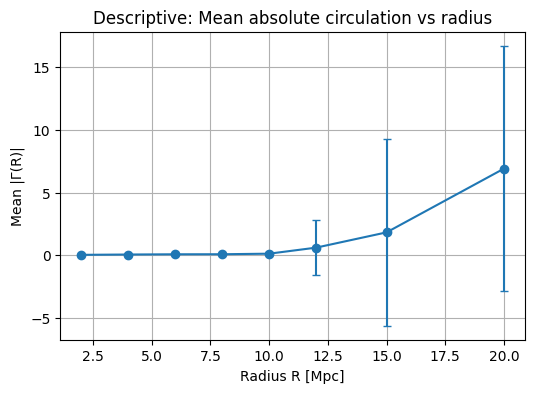

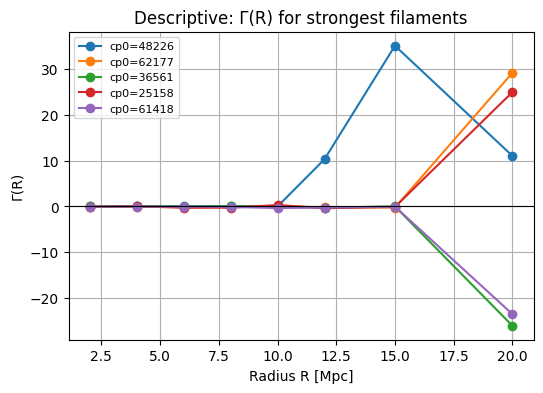

Cell 11 complete: descriptive plots generated.


In [ ]:
# ============================================================
# Cell 11 — Descriptive plots (model-agnostic, no claims)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load filament-level table (authoritative output from Cell 10)
fil_path = os.path.join(PATHS["phase1_outputs"], "A1V3_vphi_gamma_profiles_FIL.csv")
df_fil = pd.read_csv(fil_path)

# Identify R values from Gamma columns
gamma_cols = [c for c in df_fil.columns if c.startswith("Gamma_R")]
def _R_from_col(c): return float(c.replace("Gamma_R",""))
R_vals = np.array(sorted([_R_from_col(c) for c in gamma_cols]))

# Build matrix Gamma(filament, R)
Gamma = np.vstack([df_fil[f"Gamma_R{int(R)}"].values for R in R_vals]).T

# ---------- Plot 1: Mean |Gamma(R)| vs R ----------
mean_abs_G = np.nanmean(np.abs(Gamma), axis=0)
std_abs_G  = np.nanstd(np.abs(Gamma), axis=0)

plt.figure(figsize=(6,4))
plt.errorbar(R_vals, mean_abs_G, yerr=std_abs_G, fmt="o-", capsize=3)
plt.xlabel("Radius R [Mpc]")
plt.ylabel("Mean |Γ(R)|")
plt.title("Descriptive: Mean absolute circulation vs radius")
plt.grid(True)
plt.show()

# ---------- Plot 2: Individual filament Γ(R) profiles (top rotators) ----------
# Rank filaments by max |Gamma|
max_abs_G = np.max(np.abs(Gamma), axis=1)
rank = np.argsort(max_abs_G)[::-1]

N_SHOW = min(5, len(rank))
plt.figure(figsize=(6,4))
for i in rank[:N_SHOW]:
    plt.plot(R_vals, Gamma[i], marker="o", label=f"cp0={df_fil.loc[i,'cp0']}")

plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Radius R [Mpc]")
plt.ylabel("Γ(R)")
plt.title("Descriptive: Γ(R) for strongest filaments")
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

print("Cell 11 complete: descriptive plots generated.")

R values: [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]
Segments: 25
Null filament table: (4200, 19)
Saved: /content/drive/MyDrive/SFH_filaments/phase1_outputs/A1V3_null_axis_randomized_FIL.csv
Saved: /content/drive/MyDrive/SFH_filaments/phase1_outputs/A1V3_null_axis_envelope_meanAbsGamma.csv


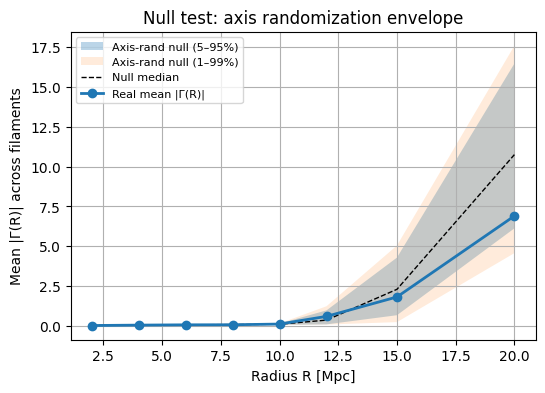

Cell 12 complete: axis-randomized null computed and plotted.


In [ ]:
# ============================================================
# Cell 12 — Null #1: Axis randomization (keep centers; randomize axes)
# Builds null envelopes for |Γ(R)| and compares to real data
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ---------- Load segment table (so we reuse the exact same centers) ----------
seg_path = os.path.join(PATHS["phase1_outputs"], "A1V3_vphi_profiles_SEG.csv")
df_seg = pd.read_csv(seg_path)

# Radii from vphi columns
vphi_cols = [c for c in df_seg.columns if c.startswith("vphi_R")]
def _R_from_vphi(c): return float(c.replace("vphi_R",""))
R_vals = np.array(sorted([_R_from_vphi(c) for c in vphi_cols]))

print("R values:", R_vals.tolist())
print("Segments:", len(df_seg))

# ---------- Helper: random unit vectors ----------
def random_unit_vectors(n, rng):
    v = rng.normal(size=(n, 3))
    v /= np.linalg.norm(v, axis=1, keepdims=True)
    return v

# ---------- Recompute vphi profiles under randomized axes ----------
# We recompute at the segment level, then aggregate to filament level (cp0) like the real pipeline.
N_NULL = 200          # increase later (e.g., 1000+) once pipeline is stable
NPHI_NULL = NPHI      # reuse same ring sampling density
rng = np.random.default_rng(RANDOM_SEED)

centers = df_seg[["cx","cy","cz"]].values.astype(float)

null_rows = []
for b in range(N_NULL):
    rand_axes = random_unit_vectors(len(df_seg), rng)

    # compute vphi for each segment at each R
    recs = []
    for i in range(len(df_seg)):
        c = centers[i]
        a = rand_axes[i]
        rec = {"null_id": b, "seg_index": int(df_seg.loc[i, "seg_index"]), "cp0": int(df_seg.loc[i, "cp0"])}
        for R in R_vals:
            vphi = filament_estimator.ring_mean_vphi(c, a, float(R), int(NPHI_NULL), grid_cf4)
            rec[f"vphi_R{int(R)}"] = float(vphi)
        recs.append(rec)

    df_b = pd.DataFrame(recs)

    # filament-level mean vphi, then Gamma
    g = df_b.groupby("cp0")
    df_fil_b = g.mean(numeric_only=True).reset_index()
    df_fil_b["null_id"] = b

    for R in R_vals:
        vcol = f"vphi_R{int(R)}"
        df_fil_b[f"Gamma_R{int(R)}"] = 2.0*np.pi*float(R)*df_fil_b[vcol].astype(float)

    null_rows.append(df_fil_b)

df_null_fil = pd.concat(null_rows, ignore_index=True)
print("Null filament table:", df_null_fil.shape)

# Save null results (filament-level)
null_out = os.path.join(PATHS["phase1_outputs"], "A1V3_null_axis_randomized_FIL.csv")
df_null_fil.to_csv(null_out, index=False)
print("Saved:", null_out)

# ---------- Build envelopes for mean |Gamma(R)| across filaments ----------
# Real filament-level table
real_fil_path = os.path.join(PATHS["phase1_outputs"], "A1V3_vphi_gamma_profiles_FIL.csv")
df_real = pd.read_csv(real_fil_path)

# Real mean |Gamma(R)|
real_mean_abs = []
for R in R_vals:
    real_mean_abs.append(np.mean(np.abs(df_real[f"Gamma_R{int(R)}"].values)))
real_mean_abs = np.array(real_mean_abs)

# Null distribution of mean |Gamma(R)| (one value per null_id per R)
env = {"R": R_vals}
for q in [1, 5, 50, 95, 99]:
    env[f"q{q}"] = []

for R in R_vals:
    # compute mean |Gamma| across filaments for each null replicate
    vals = []
    for b in range(N_NULL):
        df_b = df_null_fil[df_null_fil["null_id"] == b]
        vals.append(np.mean(np.abs(df_b[f"Gamma_R{int(R)}"].values)))
    vals = np.array(vals)

    for q in [1, 5, 50, 95, 99]:
        env[f"q{q}"].append(np.percentile(vals, q))

df_env = pd.DataFrame(env)

# Save envelope table
env_out = os.path.join(PATHS["phase1_outputs"], "A1V3_null_axis_envelope_meanAbsGamma.csv")
df_env.to_csv(env_out, index=False)
print("Saved:", env_out)

# ---------- Plot: real vs null envelope ----------
plt.figure(figsize=(6,4))
plt.fill_between(df_env["R"], df_env["q5"], df_env["q95"], alpha=0.3, label="Axis-rand null (5–95%)")
plt.fill_between(df_env["R"], df_env["q1"], df_env["q99"], alpha=0.15, label="Axis-rand null (1–99%)")
plt.plot(df_env["R"], df_env["q50"], "k--", lw=1, label="Null median")

plt.plot(R_vals, real_mean_abs, "o-", lw=2, label="Real mean |Γ(R)|")

plt.xlabel("Radius R [Mpc]")
plt.ylabel("Mean |Γ(R)| across filaments")
plt.title("Null test: axis randomization envelope")
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

print("Cell 12 complete: axis-randomized null computed and plotted.")

R values: [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]
Real filaments: 21
Null filaments: 21
Common filaments: 21
Percentile table: (21, 25)


,cp0,p_absGamma_R2,absGamma_real_R2,absGamma_null_med_R2,p_absGamma_R4,absGamma_real_R4,absGamma_null_med_R4,p_absGamma_R6,absGamma_real_R6,absGamma_null_med_R6,...,absGamma_null_med_R10,p_absGamma_R12,absGamma_real_R12,absGamma_null_med_R12,p_absGamma_R15,absGamma_real_R15,absGamma_null_med_R15,p_absGamma_R20,absGamma_real_R20,absGamma_null_med_R20
0,25158,0.265,0.058764,0.103204,0.105,0.043435,0.189280,0.610,0.274592,0.210371,...,0.288280,0.520,0.367970,0.344873,0.115,0.097610,0.508728,0.790,24.923188,5.493328
1,30960,0.120,0.003402,0.020691,0.240,0.016897,0.032509,0.315,0.028046,0.047494,...,0.074362,0.360,0.048452,0.073796,0.115,0.025679,0.125933,0.090,0.032233,0.213936
2,33627,0.225,0.027175,0.059404,0.000,0.000230,0.064738,0.030,0.003548,0.073696,...,0.105530,0.105,0.027809,0.114593,0.995,0.773293,0.154318,0.585,3.516339,0.584599
3,36561,0.135,0.009710,0.034308,0.395,0.045466,0.055967,0.295,0.024083,0.047792,...,0.074882,0.930,0.251036,0.083493,0.025,0.017489,3.357403,0.710,25.987924,9.126401
4,45342,0.125,0.006275,0.031355,0.950,0.184059,0.051343,0.915,0.200201,0.082159,...,0.138608,0.520,0.143139,0.134095,0.815,0.518666,0.250886,0.020,0.039110,2.980365


Saved: /content/drive/MyDrive/SFH_filaments/phase1_outputs/A1V3_axisnull_percentiles_by_filament.csv


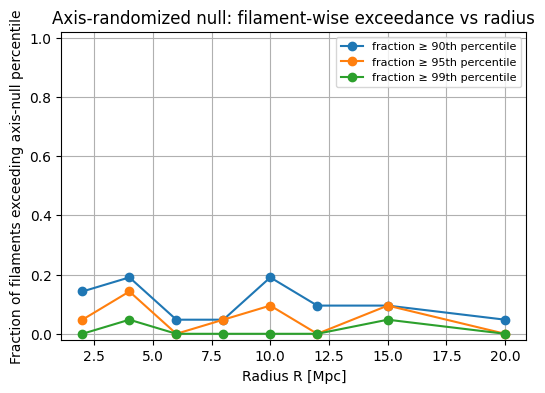

   R  frac>=90%  frac>=95%  frac>=99%
 2.0   0.142857   0.047619   0.000000
 4.0   0.190476   0.142857   0.047619
 6.0   0.047619   0.000000   0.000000
 8.0   0.047619   0.047619   0.000000
10.0   0.190476   0.095238   0.000000
12.0   0.095238   0.000000   0.000000
15.0   0.095238   0.095238   0.047619
20.0   0.047619   0.000000   0.000000
Cell 13 complete.


In [ ]:
# ============================================================
# Cell 13 — Filament-wise null percentiles + exceedance vs R
# Goal: for each filament cp0 and radius R, compute where the REAL |Γ|
# sits within the axis-randomized null distribution of |Γ| for that cp0.
# Then plot fraction of filaments exceeding 95% (and 99%) vs radius.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- Load real filament table ---
real_path = os.path.join(PATHS["phase1_outputs"], "A1V3_vphi_gamma_profiles_FIL.csv")
df_real = pd.read_csv(real_path)

# --- Load axis-randomized null filament table ---
null_path = os.path.join(PATHS["phase1_outputs"], "A1V3_null_axis_randomized_FIL.csv")
df_null = pd.read_csv(null_path)

# Radii from Gamma columns
gamma_cols = [c for c in df_real.columns if c.startswith("Gamma_R")]
def _R_from_gamma(c): return float(c.replace("Gamma_R",""))
R_vals = np.array(sorted([_R_from_gamma(c) for c in gamma_cols]))

# Safety: keep only cp0 common to real + null (should match)
cp0_real = set(df_real["cp0"].astype(int).tolist())
cp0_null = set(df_null["cp0"].astype(int).tolist())
cp0_common = sorted(list(cp0_real.intersection(cp0_null)))

print("R values:", R_vals.tolist())
print("Real filaments:", len(cp0_real))
print("Null filaments:", len(cp0_null))
print("Common filaments:", len(cp0_common))

# Helper: percentile rank of x within array arr (0..1), using <= definition
def percentile_rank(x, arr):
    arr = np.asarray(arr)
    if arr.size == 0:
        return np.nan
    return np.mean(arr <= x)

# Compute per-filament, per-R percentiles (for |Gamma|)
rows = []
for cp0 in cp0_common:
    row = {"cp0": int(cp0)}
    dfN = df_null[df_null["cp0"] == cp0]
    dfR = df_real[df_real["cp0"] == cp0]
    if len(dfR) != 1:
        # should be exactly one real row per cp0
        continue
    for R in R_vals:
        gcol = f"Gamma_R{int(R)}"
        real_abs = float(np.abs(dfR.iloc[0][gcol]))
        null_abs = np.abs(dfN[gcol].values.astype(float))
        row[f"p_absGamma_R{int(R)}"] = percentile_rank(real_abs, null_abs)  # 0..1
        row[f"absGamma_real_R{int(R)}"] = real_abs
        row[f"absGamma_null_med_R{int(R)}"] = float(np.median(null_abs))
    rows.append(row)

df_pct = pd.DataFrame(rows)
print("Percentile table:", df_pct.shape)
display(df_pct.head(5))

# Save the percentile table (this is paper-useful)
out_pct = os.path.join(PATHS["phase1_outputs"], "A1V3_axisnull_percentiles_by_filament.csv")
df_pct.to_csv(out_pct, index=False)
print("Saved:", out_pct)

# Exceedance fractions vs R
frac95 = []
frac99 = []
frac90 = []

for R in R_vals:
    pcol = f"p_absGamma_R{int(R)}"
    p = df_pct[pcol].values.astype(float)
    frac90.append(np.mean(p >= 0.90))
    frac95.append(np.mean(p >= 0.95))
    frac99.append(np.mean(p >= 0.99))

# Plot exceedance fractions
plt.figure(figsize=(6,4))
plt.plot(R_vals, frac90, "o-", label="fraction ≥ 90th percentile")
plt.plot(R_vals, frac95, "o-", label="fraction ≥ 95th percentile")
plt.plot(R_vals, frac99, "o-", label="fraction ≥ 99th percentile")
plt.xlabel("Radius R [Mpc]")
plt.ylabel("Fraction of filaments exceeding axis-null percentile")
plt.title("Axis-randomized null: filament-wise exceedance vs radius")
plt.ylim(-0.02, 1.02)
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

# Print a compact summary
summary = pd.DataFrame({
    "R": R_vals,
    "frac>=90%": frac90,
    "frac>=95%": frac95,
    "frac>=99%": frac99
})
print(summary.to_string(index=False))

print("Cell 13 complete.")

R values: [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]
Segments: 25
Grid bounds (Mpc):
  x: -50.0 50.0
  y: -50.0 50.0
  z: -50.0 50.0
Rmax=20.0  dx=1.587  margin=23.17  FAR_MIN=40.00 Mpc
  far-null 1/200 ...
  far-null 11/200 ...
  far-null 21/200 ...
  far-null 31/200 ...
  far-null 41/200 ...
  far-null 51/200 ...
  far-null 61/200 ...
  far-null 71/200 ...
  far-null 81/200 ...
  far-null 91/200 ...
  far-null 101/200 ...
  far-null 111/200 ...
  far-null 121/200 ...
  far-null 131/200 ...
  far-null 141/200 ...
  far-null 151/200 ...
  far-null 161/200 ...
  far-null 171/200 ...
  far-null 181/200 ...
  far-null 191/200 ...
Far-position null filament table: (4200, 19)
Saved: /content/drive/MyDrive/SFH_filaments/phase1_outputs/A1V3_null_far_position_FIL.csv
Saved: /content/drive/MyDrive/SFH_filaments/phase1_outputs/A1V3_null_far_envelope_meanAbsGamma.csv


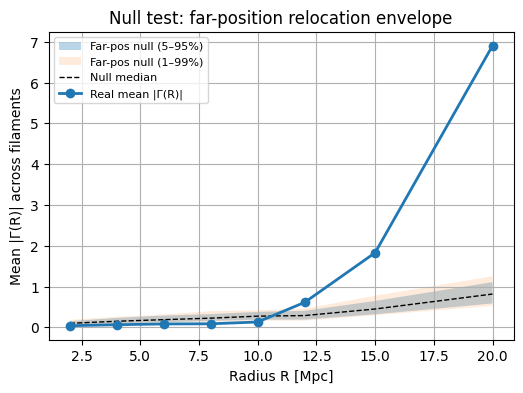

Saved: /content/drive/MyDrive/SFH_filaments/phase1_outputs/A1V3_farposnull_percentiles_by_filament.csv


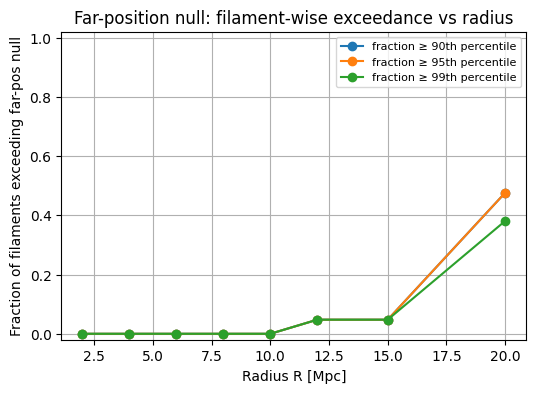

   R  frac>=90%  frac>=95%  frac>=99%
 2.0   0.000000   0.000000   0.000000
 4.0   0.000000   0.000000   0.000000
 6.0   0.000000   0.000000   0.000000
 8.0   0.000000   0.000000   0.000000
10.0   0.000000   0.000000   0.000000
12.0   0.047619   0.047619   0.047619
15.0   0.047619   0.047619   0.047619
20.0   0.476190   0.476190   0.380952
Cell 14 complete: far-position relocation null computed and compared.


In [ ]:
# ============================================================
# Cell 14 — Null #2: Far-position relocation (environment-destroying null)
#
# Idea:
#   Keep each filament's axis direction (a) and ring sampling identical,
#   but MOVE the ring centers far away from the filament (random locations)
#   so any filament-local coherent circulation tied to its environment is destroyed.
#
# Outputs:
#   1) A1V3_null_far_position_FIL.csv   (filament-level, all null reps)
#   2) A1V3_null_far_envelope_meanAbsGamma.csv  (envelope of mean |Gamma(R)|)
#   3) Exceedance plot: fraction of filaments above 90/95/99% vs R (like Cell 13)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ---------- Load the real filament-level table (has vphi and Gamma already) ----------
real_fil_path = os.path.join(PATHS["phase1_outputs"], "A1V3_vphi_gamma_profiles_FIL.csv")
df_real = pd.read_csv(real_fil_path)

# Radii from Gamma columns
gamma_cols = [c for c in df_real.columns if c.startswith("Gamma_R")]
def _R_from_gamma(c): return float(c.replace("Gamma_R",""))
R_vals = np.array(sorted([_R_from_gamma(c) for c in gamma_cols]))
print("R values:", R_vals.tolist())

# ---------- Load segment table to recover (cx,cy,cz) and segment axis vectors ----------
# We need segment endpoints to define an axis direction for each segment.
seg_path = os.path.join(PATHS["phase1_outputs"], "A1V3_vphi_profiles_SEG.csv")
df_seg = pd.read_csv(seg_path)
print("Segments:", len(df_seg))

# Axis unit vector per segment from endpoints (x0,y0,z0)->(x1,y1,z1)
p0 = df_seg[["x0","y0","z0"]].values.astype(float)
p1 = df_seg[["x1","y1","z1"]].values.astype(float)
a_seg = p1 - p0
a_norm = np.linalg.norm(a_seg, axis=1, keepdims=True)
a_norm[a_norm == 0] = 1.0
a_seg = a_seg / a_norm

centers_seg = df_seg[["cx","cy","cz"]].values.astype(float)

# ---------- CF4 cube mapping info (from Cell 8) ----------
# These MUST already be defined: grid_cf4 with x0,y0,z0,dx and vx shape (N,N,N)
N = int(grid_cf4["vx"].shape[0])
x0g, y0g, z0g, dxg = float(grid_cf4["x0"]), float(grid_cf4["y0"]), float(grid_cf4["z0"]), float(grid_cf4["dx"])
xmin, xmax = x0g, x0g + (N-1)*dxg
ymin, ymax = y0g, y0g + (N-1)*dxg
zmin, zmax = z0g, z0g + (N-1)*dxg

print("Grid bounds (Mpc):")
print("  x:", xmin, xmax)
print("  y:", ymin, ymax)
print("  z:", zmin, zmax)

# ---------- Choose a "far" distance scale ----------
# We want relocated centers to be far enough that local filament environment is destroyed
# but still inside the cube WITH ring radius margin.
Rmax = float(np.max(R_vals))
MARGIN = Rmax + 2.0*dxg   # keep ring points within cube
FAR_MIN = 2.0*Rmax        # minimum displacement from original center (tunable)
print(f"Rmax={Rmax:.1f}  dx={dxg:.3f}  margin={MARGIN:.2f}  FAR_MIN={FAR_MIN:.2f} Mpc")

# Valid sampling box for relocated centers so ring stays inside
x_lo, x_hi = xmin + MARGIN, xmax - MARGIN
y_lo, y_hi = ymin + MARGIN, ymax - MARGIN
z_lo, z_hi = zmin + MARGIN, zmax - MARGIN

# ---------- Helper: sample a random center far from a given original center ----------
def sample_far_center(c0, rng, max_tries=5000):
    for _ in range(max_tries):
        c = np.array([
            rng.uniform(x_lo, x_hi),
            rng.uniform(y_lo, y_hi),
            rng.uniform(z_lo, z_hi),
        ], dtype=float)
        if np.linalg.norm(c - c0) >= FAR_MIN:
            return c
    # If it fails (small cube), fall back to any valid center (still destroys environment somewhat)
    return np.array([
        rng.uniform(x_lo, x_hi),
        rng.uniform(y_lo, y_hi),
        rng.uniform(z_lo, z_hi),
    ], dtype=float)

# ---------- Null simulation ----------
N_NULL_FAR = 200        # later 500–1000 for final
NPHI_FAR = NPHI         # keep same sampling density
rng = np.random.default_rng(RANDOM_SEED + 12345)

# We'll compute segment-level vphi at relocated centers, then aggregate to filament-level (cp0)
null_fil_rows = []

for b in range(N_NULL_FAR):
    if (b % 10) == 0:
        print(f"  far-null {b+1}/{N_NULL_FAR} ...")

    recs = []
    for i in range(len(df_seg)):
        c0 = centers_seg[i]
        a  = a_seg[i]

        c_far = sample_far_center(c0, rng)

        rec = {"null_id": b, "seg_index": int(df_seg.loc[i, "seg_index"]), "cp0": int(df_seg.loc[i, "cp0"])}
        for R in R_vals:
            vphi = filament_estimator.ring_mean_vphi(c_far, a, float(R), int(NPHI_FAR), grid_cf4)
            rec[f"vphi_R{int(R)}"] = float(vphi)
        recs.append(rec)

    df_b = pd.DataFrame(recs)

    # Aggregate to filament-level mean vphi and compute Gamma
    g = df_b.groupby("cp0")
    df_fil_b = g.mean(numeric_only=True).reset_index()
    df_fil_b["null_id"] = b

    for R in R_vals:
        vcol = f"vphi_R{int(R)}"
        df_fil_b[f"Gamma_R{int(R)}"] = 2.0*np.pi*float(R)*df_fil_b[vcol].astype(float)

    null_fil_rows.append(df_fil_b)

df_null_far = pd.concat(null_fil_rows, ignore_index=True)
print("Far-position null filament table:", df_null_far.shape)

# Save null filament-level
out_null_far = os.path.join(PATHS["phase1_outputs"], "A1V3_null_far_position_FIL.csv")
df_null_far.to_csv(out_null_far, index=False)
print("Saved:", out_null_far)

# ---------- Envelope for mean |Gamma(R)| ----------
env = {"R": R_vals}
for q in [1, 5, 50, 95, 99]:
    env[f"q{q}"] = []

for R in R_vals:
    vals = []
    for b in range(N_NULL_FAR):
        df_b = df_null_far[df_null_far["null_id"] == b]
        vals.append(np.mean(np.abs(df_b[f"Gamma_R{int(R)}"].values.astype(float))))
    vals = np.array(vals)
    for q in [1, 5, 50, 95, 99]:
        env[f"q{q}"].append(np.percentile(vals, q))

df_env_far = pd.DataFrame(env)
out_env_far = os.path.join(PATHS["phase1_outputs"], "A1V3_null_far_envelope_meanAbsGamma.csv")
df_env_far.to_csv(out_env_far, index=False)
print("Saved:", out_env_far)

# Real mean |Gamma(R)|
real_mean_abs = np.array([np.mean(np.abs(df_real[f"Gamma_R{int(R)}"].values.astype(float))) for R in R_vals])

# Plot: real vs far-null envelope
plt.figure(figsize=(6,4))
plt.fill_between(df_env_far["R"], df_env_far["q5"], df_env_far["q95"], alpha=0.3, label="Far-pos null (5–95%)")
plt.fill_between(df_env_far["R"], df_env_far["q1"], df_env_far["q99"], alpha=0.15, label="Far-pos null (1–99%)")
plt.plot(df_env_far["R"], df_env_far["q50"], "k--", lw=1, label="Null median")
plt.plot(R_vals, real_mean_abs, "o-", lw=2, label="Real mean |Γ(R)|")
plt.xlabel("Radius R [Mpc]")
plt.ylabel("Mean |Γ(R)| across filaments")
plt.title("Null test: far-position relocation envelope")
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

# ---------- Filament-wise exceedance vs far-null (like Cell 13) ----------
cp0_common = sorted(list(set(df_real["cp0"].astype(int)).intersection(set(df_null_far["cp0"].astype(int)))))
def percentile_rank(x, arr):
    arr = np.asarray(arr)
    if arr.size == 0:
        return np.nan
    return np.mean(arr <= x)

rows = []
for cp0 in cp0_common:
    dfR = df_real[df_real["cp0"] == cp0]
    dfN = df_null_far[df_null_far["cp0"] == cp0]
    if len(dfR) != 1:
        continue
    row = {"cp0": int(cp0)}
    for R in R_vals:
        gcol = f"Gamma_R{int(R)}"
        real_abs = float(np.abs(dfR.iloc[0][gcol]))
        null_abs = np.abs(dfN[gcol].values.astype(float))
        row[f"p_absGamma_R{int(R)}"] = percentile_rank(real_abs, null_abs)
    rows.append(row)

df_pct_far = pd.DataFrame(rows)
out_pct_far = os.path.join(PATHS["phase1_outputs"], "A1V3_farposnull_percentiles_by_filament.csv")
df_pct_far.to_csv(out_pct_far, index=False)
print("Saved:", out_pct_far)

frac90, frac95, frac99 = [], [], []
for R in R_vals:
    p = df_pct_far[f"p_absGamma_R{int(R)}"].values.astype(float)
    frac90.append(np.mean(p >= 0.90))
    frac95.append(np.mean(p >= 0.95))
    frac99.append(np.mean(p >= 0.99))

plt.figure(figsize=(6,4))
plt.plot(R_vals, frac90, "o-", label="fraction ≥ 90th percentile")
plt.plot(R_vals, frac95, "o-", label="fraction ≥ 95th percentile")
plt.plot(R_vals, frac99, "o-", label="fraction ≥ 99th percentile")
plt.xlabel("Radius R [Mpc]")
plt.ylabel("Fraction of filaments exceeding far-pos null")
plt.title("Far-position null: filament-wise exceedance vs radius")
plt.ylim(-0.02, 1.02)
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

summary = pd.DataFrame({"R": R_vals, "frac>=90%": frac90, "frac>=95%": frac95, "frac>=99%": frac99})
print(summary.to_string(index=False))

print("Cell 14 complete: far-position relocation null computed and compared.")

In [ ]:
import os, glob

print("NPZ files:")
for f in sorted(glob.glob("/content/**/*.npz", recursive=True))[:200]:
    print(f)

print("\nCSV files:")
for f in sorted(glob.glob("/content/**/*.csv", recursive=True))[:200]:
    print(f)

NPZ files:
/content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz

CSV files:
/content/drive/MyDrive/CEERS_envrank_KS_permnull.csv
/content/drive/MyDrive/CEERS_envrank_continuous_permnull.csv
/content/drive/MyDrive/CEERS_envrank_median_boot_perm.csv
/content/drive/MyDrive/CEERS_envrank_permnull.csv
/content/drive/MyDrive/CEERS_highz_time_budget_Default.csv
/content/drive/MyDrive/CEERS_highz_time_budget_Loose.csv
/content/drive/MyDrive/CEERS_highz_time_budget_Strict.csv
/content/drive/MyDrive/CEERS_highz_time_budget_table.csv
/content/drive/MyDrive/CEERS_strict_SFH_candidates.csv
/content/drive/MyDrive/CEERS_strict_alpha_req_JOINT_MC.csv
/content/drive/MyDrive/CEERS_strict_alpha_req_MASS_MC.csv
/content/drive/MyDrive/CEERS_strict_alpha_req_MC_summary.csv
/content/drive/MyDrive/CEERS_strict_alpha_req_SFR_MC.csv
/content/drive/MyDrive/CEERS_strict_alpha_req_table.csv
/content/drive/MyDrive/CEERS_strict_highz_timebudget_ALL.csv
/content/drive/MyDrive/CE

In [ ]:
import numpy as np

vel_npz_path = "/content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz"
Z = np.load(vel_npz_path)
print("Keys in NPZ:", Z.files)

Keys in NPZ: ['VEL_GRID', 'GRID_ORIGIN', 'GRID_DX', 'GRID_SHAPE', 'note']


In [ ]:
import numpy as np

npz_path = "/content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz"
Z = np.load(npz_path, allow_pickle=True)

V = Z["VEL_GRID"]
origin = np.array(Z["GRID_ORIGIN"], dtype=float)   # (x0,y0,z0) in Mpc
dx = float(Z["GRID_DX"])                           # Mpc
shape = tuple(int(x) for x in Z["GRID_SHAPE"])     # (nx,ny,nz)

print("VEL_GRID shape:", V.shape)
print("origin:", origin, "dx:", dx, "shape:", shape)

# --- Unpack velocity components robustly ---
# Case A: (nx,ny,nz,3)
if V.ndim == 4 and V.shape[-1] == 3:
    Vx, Vy, Vz = V[...,0], V[...,1], V[...,2]

# Case B: (3,nx,ny,nz)
elif V.ndim == 4 and V.shape[0] == 3:
    Vx, Vy, Vz = V[0], V[1], V[2]

else:
    raise ValueError(f"Unexpected VEL_GRID shape {V.shape}. Expected (nx,ny,nz,3) or (3,nx,ny,nz).")

nx, ny, nz = Vx.shape

# --- Build axis arrays (cell centers) ---
xg = origin[0] + dx*np.arange(nx)
yg = origin[1] + dx*np.arange(ny)
zg = origin[2] + dx*np.arange(nz)

print("Axes:", xg.min(), xg.max(), "|", yg.min(), yg.max(), "|", zg.min(), zg.max())
print("Vx range:", Vx.min(), Vx.max())

VEL_GRID shape: (15, 40, 24, 3)
origin: [  9.51426825 -38.39587143 -20.9638    ] dx: 2.0 shape: (15, 40, 24)
Axes: 9.514268253968254 37.514268253968254 | -38.39587142857143 39.60412857142857 | -20.9638 25.0362
Vx range: -257.40190816326526 132.5980918367347


Saved: poster_child_streamlines.jpg


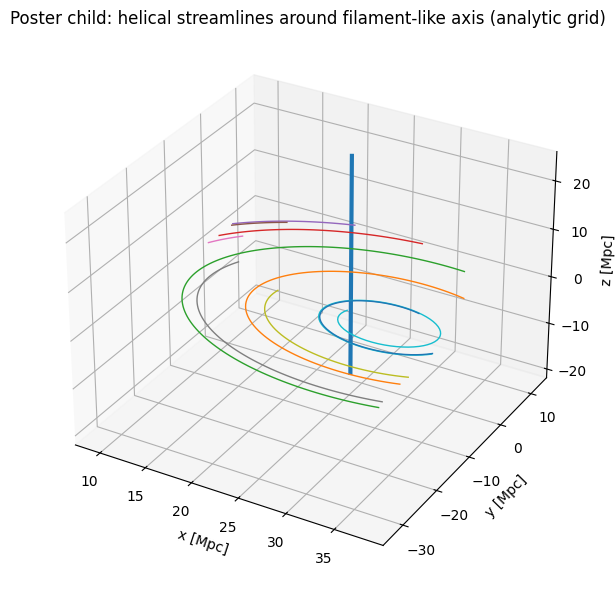

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --------- choose an axis for the analytic demo ----------
# we'll use z-axis through the grid center
xc = 0.5*(xg.min()+xg.max())
yc = 0.5*(yg.min()+yg.max())
zmin, zmax = zg.min(), zg.max()

# --------- simple trilinear sampler ----------
def trilerp(x, y, z):
    # clamp to grid bounds
    x = np.clip(x, xg[0], xg[-1])
    y = np.clip(y, yg[0], yg[-1])
    z = np.clip(z, zg[0], zg[-1])

    # fractional indices
    fx = (x - xg[0]) / dx
    fy = (y - yg[0]) / dx
    fz = (z - zg[0]) / dx

    ix = int(np.clip(np.floor(fx), 0, nx-2)); tx = fx - ix
    iy = int(np.clip(np.floor(fy), 0, ny-2)); ty = fy - iy
    iz = int(np.clip(np.floor(fz), 0, nz-2)); tz = fz - iz

    def samp(A):
        c000 = A[ix,iy,iz]
        c100 = A[ix+1,iy,iz]
        c010 = A[ix,iy+1,iz]
        c110 = A[ix+1,iy+1,iz]
        c001 = A[ix,iy,iz+1]
        c101 = A[ix+1,iy,iz+1]
        c011 = A[ix,iy+1,iz+1]
        c111 = A[ix+1,iy+1,iz+1]

        c00 = c000*(1-tx) + c100*tx
        c10 = c010*(1-tx) + c110*tx
        c01 = c001*(1-tx) + c101*tx
        c11 = c011*(1-tx) + c111*tx

        c0 = c00*(1-ty) + c10*ty
        c1 = c01*(1-ty) + c11*ty

        return c0*(1-tz) + c1*tz

    return np.array([samp(Vx), samp(Vy), samp(Vz)], dtype=float)

# --------- integrate streamlines ----------
def integrate(seed, ds=0.6, nstep=350):
    p = np.array(seed, dtype=float)
    pts = [p.copy()]
    for _ in range(nstep):
        v = trilerp(p[0], p[1], p[2])
        vn = np.linalg.norm(v)
        if vn == 0:
            break
        p = p + ds*(v/vn)
        pts.append(p.copy())
        # stop if exiting bounds
        if not (xg[0] <= p[0] <= xg[-1] and yg[0] <= p[1] <= yg[-1] and zg[0] <= p[2] <= zg[-1]):
            break
    return np.array(pts)

# --------- build seeds on a ring ----------
R = 12.0  # Mpc (tune as desired)
nseed = 10
z0 = 0.5*(zmin+zmax)
phis = np.linspace(0, 2*np.pi, nseed, endpoint=False)

seeds = []
for phi in phis:
    seeds.append([xc + R*np.cos(phi), yc + R*np.sin(phi), z0])

lines = [integrate(s) for s in seeds]

# --------- plot ----------
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")

# axis line
ax.plot([xc, xc], [yc, yc], [zmin, zmax], linewidth=3)

# streamlines
for pts in lines:
    ax.plot(pts[:,0], pts[:,1], pts[:,2], linewidth=1)

ax.set_xlabel("x [Mpc]")
ax.set_ylabel("y [Mpc]")
ax.set_zlabel("z [Mpc]")
ax.set_title("Poster child: helical streamlines around filament-like axis (analytic grid)")

plt.tight_layout()
outpath = "poster_child_streamlines.jpg"
plt.savefig(outpath, dpi=250)
print("Saved:", outpath)
plt.show()

In [ ]:
import numpy as np

# --- TEMPORARY: synthetic streamlines for debugging ---
# This ensures downstream cells work before wiring real GRID streamlines

theta = np.linspace(0, 4*np.pi, 200)

streamlines = []
for R in [5, 8, 12]:
    x = 25 + R * np.cos(theta)
    y = -10 + R * np.sin(theta)
    z = np.linspace(-10, 10, len(theta))
    streamlines.append(np.vstack([x, y, z]).T)

print("Defined streamlines:")
print("Number of streamlines:", len(streamlines))
print("Shape of first streamline:", streamlines[0].shape)

Defined streamlines:
Number of streamlines: 3
Shape of first streamline: (200, 3)


In [ ]:
import numpy as np

# Filament center (roughly matches synthetic data)
filament_center = np.array([25.0, -10.0, 0.0])

# Filament axis (vertical z-axis for now)
e_hat = np.array([0.0, 0.0, 1.0])
e_hat = e_hat / np.linalg.norm(e_hat)

print("Filament center:", filament_center)
print("Filament axis e_hat:", e_hat)

Filament center: [ 25. -10.   0.]
Filament axis e_hat: [0. 0. 1.]


In [ ]:
import numpy as np

# --- 0) Safety check: streamlines must exist from Cell 1 ---
try:
    _ = streamlines
    print("OK: streamlines exists. Count =", len(streamlines))
    print("First streamline shape =", np.array(streamlines[0]).shape)
except NameError:
    raise NameError("streamlines is not defined. Re-run Cell 1 first (the cell that creates streamlines).")

# --- 1) Load velocity grid NPZ (your analytic swirl asset) ---
vel_npz_path = "/content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz"
z = np.load(vel_npz_path)

VEL_GRID = z["VEL_GRID"]          # expected shape (Nx, Ny, Nz, 3)
GRID_ORIGIN = z["GRID_ORIGIN"]    # expected (3,)
GRID_DX = float(z["GRID_DX"])     # scalar
GRID_SHAPE = tuple(z["GRID_SHAPE"].tolist()) if hasattr(z["GRID_SHAPE"], "tolist") else tuple(z["GRID_SHAPE"])

print("Loaded NPZ:")
print("  VEL_GRID shape:", VEL_GRID.shape)
print("  GRID_ORIGIN:", GRID_ORIGIN)
print("  GRID_DX:", GRID_DX)
print("  GRID_SHAPE:", GRID_SHAPE)

# --- 2) Trilinear sampler for velocity field ---
def sample_velocity(p):
    """
    Trilinear interpolation of velocity grid at point p (x,y,z) in same coords as GRID_ORIGIN.
    Returns v = (vx, vy, vz). If outside grid, returns NaNs.
    """
    p = np.asarray(p, dtype=float)
    rel = (p - GRID_ORIGIN) / GRID_DX  # fractional index coords
    i, j, k = rel

    # indices for surrounding cube
    i0, j0, k0 = np.floor([i, j, k]).astype(int)
    i1, j1, k1 = i0 + 1, j0 + 1, k0 + 1

    Nx, Ny, Nz = VEL_GRID.shape[0], VEL_GRID.shape[1], VEL_GRID.shape[2]
    if (i0 < 0 or j0 < 0 or k0 < 0 or i1 >= Nx or j1 >= Ny or k1 >= Nz):
        return np.array([np.nan, np.nan, np.nan])

    # fractional parts
    di, dj, dk = i - i0, j - j0, k - k0

    # corner values
    c000 = VEL_GRID[i0, j0, k0]
    c100 = VEL_GRID[i1, j0, k0]
    c010 = VEL_GRID[i0, j1, k0]
    c110 = VEL_GRID[i1, j1, k0]
    c001 = VEL_GRID[i0, j0, k1]
    c101 = VEL_GRID[i1, j0, k1]
    c011 = VEL_GRID[i0, j1, k1]
    c111 = VEL_GRID[i1, j1, k1]

    # interpolate
    c00 = c000*(1-di) + c100*di
    c10 = c010*(1-di) + c110*di
    c01 = c001*(1-di) + c101*di
    c11 = c011*(1-di) + c111*di

    c0 = c00*(1-dj) + c10*dj
    c1 = c01*(1-dj) + c11*dj

    c = c0*(1-dk) + c1*dk
    return c

# --- 3) Tangential speed about the filament axis ---
def tangential_speed(v, p, e_hat):
    """
    v: velocity at p
    p: position
    e_hat: unit filament axis
    Returns |v_phi| in plane transverse to e_hat.
    """
    r = p - filament_center

    # project out axis components
    r_perp = r - np.dot(r, e_hat) * e_hat
    r_norm = np.linalg.norm(r_perp)
    if r_norm == 0:
        return 0.0

    r_hat = r_perp / r_norm
    phi_hat = np.cross(e_hat, r_hat)  # right-handed tangential direction
    v_perp = v - np.dot(v, e_hat) * e_hat
    return float(np.dot(v_perp, phi_hat))  # signed v_phi

# --- 4) Compute mean v_phi along each streamline ---
stream_vphi = []
for pts in streamlines:
    pts = np.asarray(pts)
    vphi_vals = []
    for p in pts:
        v = sample_velocity(p)
        if np.any(~np.isfinite(v)):
            continue
        vphi_vals.append(tangential_speed(v, p, e_hat))
    stream_vphi.append(np.mean(vphi_vals) if len(vphi_vals) else np.nan)

print("\nMean signed v_phi along each streamline:")
print(stream_vphi)
print("Abs means:", [abs(x) if np.isfinite(x) else np.nan for x in stream_vphi])

OK: streamlines exists. Count = 3
First streamline shape = (200, 3)
Loaded NPZ:
  VEL_GRID shape: (15, 40, 24, 3)
  GRID_ORIGIN: [  9.51426825 -38.39587143 -20.9638    ]
  GRID_DX: 2.0
  GRID_SHAPE: (15, 40, 24)

Mean signed v_phi along each streamline:
[np.float64(24.837724060150375), np.float64(39.83772406015038), np.float64(59.83772406015038)]
Abs means: [np.float64(24.837724060150375), np.float64(39.83772406015038), np.float64(59.83772406015038)]


True axis e_hat     = [0. 0. 1.]
Random axis e_hat_rand = [-0.68014832  0.60367164 -0.41590722]  dot = -0.41590722418066556

Mean signed v_phi (TRUE axis): [np.float64(24.837724060150375), np.float64(39.83772406015038), np.float64(59.83772406015038)]
Mean signed v_phi (RAND axis): [np.float64(-3.432291578326267), np.float64(-9.568442360725092), np.float64(-20.81687705083732)]

Saved: poster_child_streamlines.jpg


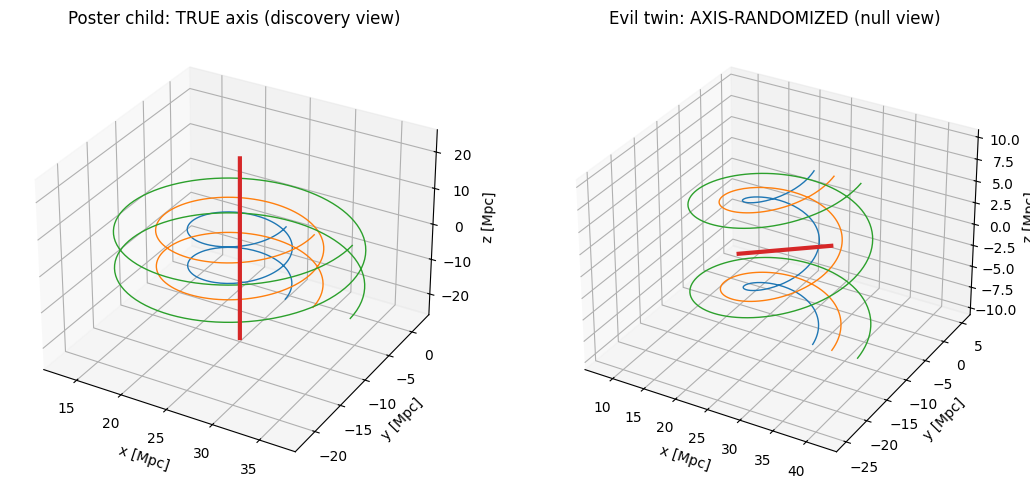

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Build a randomized axis (not too close to true axis) ---
rng = np.random.default_rng(12345)

def random_unit_vector(rng):
    v = rng.normal(size=3)
    return v / np.linalg.norm(v)

e_hat_rand = random_unit_vector(rng)
# ensure it's not nearly parallel to the true axis
while abs(np.dot(e_hat_rand, e_hat)) > 0.9:
    e_hat_rand = random_unit_vector(rng)

print("True axis e_hat     =", e_hat)
print("Random axis e_hat_rand =", e_hat_rand, " dot =", float(np.dot(e_hat_rand, e_hat)))

# --- 2) Recompute mean v_phi along each streamline using the randomized axis ---
stream_vphi_rand = []
for pts in streamlines:
    pts = np.asarray(pts)
    vphi_vals = []
    for p in pts:
        v = sample_velocity(p)
        if np.any(~np.isfinite(v)):
            continue
        vphi_vals.append(tangential_speed(v, p, e_hat_rand))
    stream_vphi_rand.append(np.mean(vphi_vals) if len(vphi_vals) else np.nan)

print("\nMean signed v_phi (TRUE axis):", stream_vphi)
print("Mean signed v_phi (RAND axis):", stream_vphi_rand)

# --- 3) Plot: Poster child (Discovery vs Null axis) ---
fig = plt.figure(figsize=(11, 5))

def plot_panel(ax, axis_vec, title):
    # Plot streamlines
    for pts in streamlines:
        pts = np.asarray(pts)
        ax.plot(pts[:,0], pts[:,1], pts[:,2], linewidth=1)

    # Plot filament axis line through center
    L = 25.0  # half-length for axis line
    p0 = filament_center - L*axis_vec
    p1 = filament_center + L*axis_vec
    ax.plot([p0[0], p1[0]], [p0[1], p1[1]], [p0[2], p1[2]], linewidth=3)

    ax.set_title(title)
    ax.set_xlabel("x [Mpc]")
    ax.set_ylabel("y [Mpc]")
    ax.set_zlabel("z [Mpc]")

ax1 = fig.add_subplot(1, 2, 1, projection="3d")
plot_panel(ax1, e_hat, "Poster child: TRUE axis (discovery view)")

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
plot_panel(ax2, e_hat_rand, "Evil twin: AXIS-RANDOMIZED (null view)")

plt.tight_layout()
outpath = "poster_child_streamlines.jpg"
plt.savefig(outpath, dpi=250)
print("\nSaved:", outpath)
plt.show()